In [526]:
import tensorflow
import pandas as pd
import time
import numpy as np
import pylab as plt
import multiprocessing as mp
import statistics
from statistics import mean

import librosa
from librosa import feature
from glob import glob
import os

from sklearn.preprocessing import StandardScaler, OneHotEncoder

# tensorflow libraries
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Conv2D, Activation
from tensorflow.keras.callbacks import Callback
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier

# sklearn libraries are useful for preprocessing, performance measures, etc.
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
min_max_scaler = preprocessing.MinMaxScaler()

In [216]:
# rootdir = '/Users/abhishekvaidyanathan/Desktop/NNDL-project/audio-files'
rootdir = '/Users/abhishekvaidyanathan/Desktop/NNDL-project/audio-files'
audio_files = []
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        audio_files.append(os.path.join(subdir, file))
audio_files = audio_files[1:]

In [217]:
audio_files[1][-33:-25]

'Actor_16'

In [218]:
dict_actors = {}
for audio_file in audio_files:
    try :
        if (len(dict_actors[audio_file[-33:-25]])>0):
            dict_actors[audio_file[-33:-25]].append(audio_file)
    except:
        dict_actors[audio_file[-33:-25]] = []
        dict_actors[audio_file[-33:-25]].append(audio_file)

In [219]:
data = pd.DataFrame(columns = ['Actor','Modality','Vocal_channel','Emotion','Emotional_intensity','Statement','Repetion','Gender','Audio_file'])

In [220]:
def get_gender(value):
    if(int(value)%2==0):
        return 1
    else :
        return 0

for keys in dict_actors:
    for files in dict_actors[keys]:
        data.loc[len(data)] = [keys,int(files[-24:-22]),int(files[-21:-19]),int(files[-18:-16]),int(files[-15:-13]),int(files[-12:-10]),int(files[-9:-7]),get_gender(files[-6:-4]),files]

In [221]:
data.head()

,Actor,Modality,Vocal_channel,Emotion,Emotional_intensity,Statement,Repetion,Gender,Audio_file
0,Actor_16,3,1,5,1,2,1,1,/Users/abhishekvaidyanathan/Desktop/NNDL-proje...
1,Actor_16,3,1,6,1,2,2,1,/Users/abhishekvaidyanathan/Desktop/NNDL-proje...
2,Actor_16,3,1,6,2,1,2,1,/Users/abhishekvaidyanathan/Desktop/NNDL-proje...
3,Actor_16,3,1,5,2,1,1,1,/Users/abhishekvaidyanathan/Desktop/NNDL-proje...
4,Actor_16,3,1,7,1,1,1,1,/Users/abhishekvaidyanathan/Desktop/NNDL-proje...


## can change the below code cell to include different set of features. 

#### right now uses mean values, can change to using raw values for each of the features. 

In [222]:
# y, sr = librosa.load(librosa.util.example_audio_file())
# temp_func = feature.spectral_bandwidth
# temp_res = temp_func(y=y, sr=sr)
# print(temp_res)
# print(temp_res.shape)
# print(np.mean(temp_res))

In [616]:
# to add:
# mfcc - use n_mfcc=13 and take mean along axis 1 [13 features]
# chroma_stft - take mean along axis 1 [12 features]
# librosa.onset.onset_strength(y=y, sr=sr) - take direct mean
# zero_crossing_rate - take direct mean
# spectral_rolloff - direct mean
# librosa.piptrack - returns pitch and magnitude, take direct means of both
# melspectrogram - take direct mean
# spectral_contrast - use axis=1 [7 features]
# tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0) [6 features]
# rms - take direct mean
# spectral_centroid - take direct mean
# spectral_bandwidth - take direct mean


def get_feature_vector(y, sr):
    feature_vector = []

    # y=fft(y)
    # y = y.astype(np.float)  
    
    # multi-dim features
    feature_vector.extend(np.mean(feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1))
    feature_vector.extend(np.mean(feature.chroma_stft(y=y, sr=sr), axis=1))
    feature_vector.extend(np.mean(feature.spectral_contrast(y=y, sr=sr), axis=1))
    feature_vector.extend(np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr),axis=1))
    feature_vector.extend(np.mean(librosa.feature.melspectrogram(y=y, sr=sr).T, axis=0))

    
    # single-dim features with special requirements
    feature_vector.append(np.mean(feature.rms(y=y)))
    feature_vector.append(np.mean(feature.zero_crossing_rate(y=y)))
    feature_vector.extend([np.mean(x) for x in librosa.piptrack(y=y, sr=sr)])
    
    # single-dim features
    feat_list = [
        librosa.onset.onset_strength,
        feature.spectral_rolloff,
        feature.melspectrogram,
        feature.spectral_centroid,
        feature.spectral_bandwidth
    ]
    
    for temp_func in feat_list:
        feature_vector.append(np.mean(temp_func(y=y, sr=sr)))
    
    return feature_vector

In [382]:
def new_feature_list(y,sr):
    feature_vector = []

    feature_vector.extend(np.mean(feature.melspectrogram(y=y, sr=sr, n_mels=128), axis=1))
    feature_vector.extend(np.mean(feature.tonnetz(y=y, sr=sr), axis=1))
    feature_vector.extend(np.mean(feature.spectral_contrast(y=y, sr=sr), axis=1))
    feature_vector.extend(np.mean(feature.chroma_stft(y=y, sr=sr), axis=1))
    feature_vector.extend(np.mean(feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1))

    return feature_vector
    

In [601]:
from scipy.fft import fft
def extract_features(y,sr):

    N = len(y)
    T = 1/sr
    y=np.abs(fft(y))  
    # ZCR
    result = []
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=y).T, axis=0)
    # result=np.hstack((result, zcr)) # stacking horizontally
    result.extend(zcr)

    # Chroma_stft
    # stft = np.abs(librosa.stft(y))
    chroma_stft = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
    result.extend(chroma_stft)
    # result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr).T, axis=0)
    result.extend(mfcc)
    # result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=y).T, axis=0)
    result.extend(rms)
    # result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr).T, axis=0)
    result.extend(mel)
    # result = np.hstack((result, mel)) # stacking horizontally  

    # result.extend(fourier)   

    return result

In [627]:
def extract_features(y,sr):
    feature_vector = []

    stft = np.abs(librosa.stft(y))
    feature_vector.extend(np.mean(feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1))
    feature_vector.extend(np.mean(librosa.feature.melspectrogram(y=y, sr=sr).T, axis=0))
    feature_vector.extend(np.mean(librosa.feature.spectral_contrast(S=stft, sr=sr).T,axis=0))
    feature_vector.extend(np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr).T,axis=0))
    feature_vector.extend(np.mean(feature.chroma_stft(S=stft, sr=sr), axis=1))

    return feature_vector


In [ ]:
audio_features = []
for i in range(data.shape[0]):
   y , sr = librosa.load(data.iloc[i]['Audio_file'],sr=None)
   feature_vector = get_feature_vector(y, sr)
   audio_features.append(feature_vector) 

In [ ]:
audio_features_new = []
for i in range(data.shape[0]):
   y , sr = librosa.load(data.iloc[i]['Audio_file'],sr=None)
   feature_vector = new_feature_list(y, sr)
   audio_features_new.append(feature_vector) 

In [605]:
# from scipy import fft 
audio_features_extracted = []
for i in range(data.shape[0]):
    y , sr = librosa.load(data.iloc[i]['Audio_file'],sr=None)
    feature_vector = extract_features(y, sr)
    audio_features_extracted.append(feature_vector) 

In [628]:
audio_features_fourier_mel = []
for i in range(data.shape[0]):
   y , sr = librosa.load(data.iloc[i]['Audio_file'],sr=None)
   feature_vector = extract_features(y, sr)
   audio_features_fourier_mel.append(feature_vector) 

In [225]:
data_features = data.copy()

In [227]:
data_features = data_features.drop("Audio_file",axis=1)
data_features.head()

,Actor,Modality,Vocal_channel,Emotion,Emotional_intensity,Statement,Repetion,Gender
0,Actor_16,3,1,5,1,2,1,1
1,Actor_16,3,1,6,1,2,2,1
2,Actor_16,3,1,6,2,1,2,1
3,Actor_16,3,1,5,2,1,1,1
4,Actor_16,3,1,7,1,1,1,1


In [228]:
data_features['librosa'] = audio_features

In [384]:
data_features['librosa_new'] = audio_features_new

In [608]:
data_features['librosa_extracted'] = audio_features_extracted

In [629]:
data_features['librosa_extracted_mel'] = audio_features_fourier_mel

In [385]:
features = pd.DataFrame(data_features['librosa'].values.tolist())
features_paper_new = pd.DataFrame(data_features['librosa_new'].values.tolist())

In [609]:
features_librosa_extract = pd.DataFrame(data_features['librosa_extracted'].values.tolist())

In [630]:
features_fourier_mel = pd.DataFrame(data_features['librosa_extracted_mel'].values.tolist())

In [234]:
statement1 = 'Kids are talking by the door'
statement2 = 'Dogs are sitting by the door'

In [235]:
features.head()

,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,45,46
0,-563.286377,49.649117,-6.105472,10.458484,-5.491507,-0.331318,-9.950725,-0.907280,-10.080274,-7.562809,...,-0.017179,0.011657,0.074035,25.221916,0.014032,1.071212,9398.629611,0.063003,5197.643881,4276.516635
1,-582.415039,53.827759,-6.217736,7.703194,-1.535678,4.751632,-11.035256,-6.731741,-12.881447,-9.406088,...,0.000783,0.008692,0.070726,27.491137,0.008244,1.116149,7682.112873,0.041392,4250.653570,3677.994703
2,-418.499878,39.591274,-25.592108,-2.834798,-5.696198,-2.106592,-18.492928,-7.546038,-12.406196,-9.510560,...,-0.001894,0.038229,0.117620,45.732632,0.038994,1.255901,10376.602564,1.021613,5423.119278,4838.148261
3,-470.210693,48.589832,-8.505500,5.728778,-3.026479,-2.571870,-14.422069,0.161090,-6.639453,-8.884863,...,0.026988,0.023401,0.070798,23.265619,0.028221,1.114969,9022.055127,0.351491,4646.002917,4298.393109
4,-650.489380,64.394165,0.832173,11.525827,-0.357532,3.591986,-6.460279,0.641584,-12.071811,-4.113931,...,-0.012801,0.004161,0.062740,30.641380,0.004725,1.239383,8093.021716,0.008922,4275.794918,3958.305217


In [387]:
features_paper_new.head()

,0,1,2,3,4,5,6,7,8,9,...,156,157,158,159,160,161,162,163,164,165
0,0.000039,0.000112,0.000192,0.002034,0.020517,0.133241,0.379351,0.242892,0.189157,0.281925,...,10.458484,-5.491507,-0.331318,-9.950725,-0.907280,-10.080274,-7.562809,-8.875374,-1.283287,-4.365211
1,0.000028,0.000043,0.000084,0.000673,0.011591,0.095355,0.240292,0.557209,0.521864,0.207996,...,7.703194,-1.535678,4.751632,-11.035256,-6.731741,-12.881447,-9.406088,-5.080708,0.433190,-7.476513
2,0.006540,0.002999,0.000936,0.000312,0.000350,0.000324,0.000364,0.000791,0.007759,0.066257,...,-2.834798,-5.696198,-2.106592,-18.492928,-7.546038,-12.406196,-9.510560,-6.937021,-1.207587,-9.490372
3,0.001436,0.001553,0.001492,0.003362,0.021105,0.169368,0.425843,0.461724,0.529893,1.220930,...,5.728778,-3.026479,-2.571870,-14.422069,0.161090,-6.639453,-8.884863,-6.192230,0.930403,-5.094487
4,0.000047,0.000212,0.000603,0.005183,0.033828,0.084126,0.061574,0.055764,0.036036,0.019677,...,11.525827,-0.357532,3.591986,-6.460279,0.641584,-12.071811,-4.113931,-5.826627,1.093956,-3.341086


In [610]:
features_librosa_extract.head()

,0,1,2,3,4,5,6,7,8,9,...,152,153,154,155,156,157,158,159,160,161
0,0.0,0.684547,0.703801,0.739178,0.767500,0.772059,0.747136,0.736861,0.706037,0.679822,...,37.498539,65.380089,102.250580,336.373718,174.584000,48.000237,64.183609,36.662350,15.651843,9.692859
1,0.0,0.640757,0.632797,0.656536,0.674233,0.685647,0.746619,0.782694,0.735777,0.708224,...,90.897728,88.215508,53.167297,52.155960,9.446226,4.088308,3.314411,4.126917,3.467623,3.079471
2,0.0,0.685230,0.678196,0.701087,0.758304,0.763334,0.781930,0.766364,0.789515,0.745944,...,723.526611,1092.217041,589.912292,230.560898,304.038269,120.901283,84.838440,104.631363,101.237358,82.247528
3,0.0,0.660335,0.628404,0.578273,0.535018,0.614993,0.717878,0.728820,0.662896,0.643698,...,229.265671,980.058899,472.269684,314.909698,261.510315,148.887863,61.966644,40.011074,33.032581,38.330273
4,0.0,0.501721,0.600297,0.762025,0.856923,0.752864,0.615121,0.598163,0.560073,0.523834,...,12.529695,15.998025,39.434551,16.113348,3.308449,2.025302,1.381495,1.122789,1.002066,1.073240


In [631]:
features_fourier_mel.shape

(1440, 166)

In [236]:
features.shape

(1440, 47)

In [388]:
features_paper_new.shape

(1440, 166)

In [561]:
features_librosa_extract.shape

(1440, 162)

In [237]:
labels = data['Emotion']

In [239]:
actor_labels = pd.Series([int(x[-2:]) for x in data['Actor']], name='Actor')

In [240]:
features_values = features.values

In [389]:
features_new_values = features_paper_new.values

In [241]:
features_scaled_values = min_max_scaler.fit_transform(features_values)
features_normalised = pd.DataFrame(features_scaled_values)

In [390]:
features_scaled_values_new = min_max_scaler.fit_transform(features_new_values)
features_normalised = pd.DataFrame(features_scaled_values_new)

In [611]:
features_scaled_values = min_max_scaler.fit_transform(features_librosa_extract)
features_librosa_normalised = pd.DataFrame(features_scaled_values)

In [632]:
features_scaled_values = min_max_scaler.fit_transform(features_fourier_mel)
features_fourier_normalised = pd.DataFrame(features_scaled_values)

In [613]:
features_librosa_normalised.head()

,0,1,2,3,4,5,6,7,8,9,...,152,153,154,155,156,157,158,159,160,161
0,0.0,0.547651,0.593852,0.664809,0.695738,0.677995,0.601976,0.627142,0.572916,0.511306,...,0.000463,0.001338,0.001979,0.005059,0.004004,0.000801,0.001847,0.001113,0.001024,0.000437
1,0.0,0.464437,0.445763,0.493813,0.508738,0.492097,0.600790,0.730122,0.637096,0.567784,...,0.001123,0.001806,0.001029,0.000784,0.000217,0.000068,0.000095,0.000125,0.000227,0.000139
2,0.0,0.548950,0.540449,0.585994,0.677300,0.659224,0.681742,0.693432,0.753064,0.642793,...,0.008942,0.022359,0.011417,0.003467,0.006973,0.002017,0.002441,0.003178,0.006623,0.003710
3,0.0,0.501642,0.436601,0.331877,0.229611,0.340102,0.534901,0.609075,0.479817,0.439469,...,0.002833,0.020063,0.009140,0.004736,0.005997,0.002483,0.001783,0.001215,0.002161,0.001729
4,0.0,0.200226,0.377980,0.712083,0.875031,0.636701,0.299327,0.315506,0.257923,0.201113,...,0.000155,0.000327,0.000763,0.000242,0.000076,0.000034,0.000040,0.000034,0.000065,0.000048


In [393]:
features_normalised.head()

,0,1,2,3,4,5,6,7,8,9,...,156,157,158,159,160,161,162,163,164,165
0,0.000003,0.000119,0.001245,0.003530,0.014251,0.040659,0.065392,0.031983,0.017210,0.022682,...,0.517521,0.396415,0.290225,0.499093,0.481180,0.412810,0.480568,0.309155,0.430474,0.334003
1,0.000002,0.000045,0.000541,0.001166,0.008049,0.029096,0.041419,0.073380,0.047492,0.016733,...,0.466561,0.486081,0.417540,0.472050,0.306736,0.311427,0.416682,0.452662,0.481051,0.216278
2,0.000532,0.003194,0.006077,0.000540,0.000238,0.000093,0.000057,0.000097,0.000700,0.005329,...,0.271655,0.391775,0.245759,0.286085,0.282348,0.328628,0.413061,0.382460,0.432704,0.140078
3,0.000117,0.001654,0.009685,0.005837,0.014659,0.051684,0.073406,0.060804,0.048223,0.098233,...,0.430043,0.452289,0.234105,0.387596,0.513178,0.537343,0.434747,0.410627,0.495702,0.306409
4,0.000004,0.000225,0.003912,0.008999,0.023500,0.025669,0.010609,0.007337,0.003274,0.001581,...,0.537263,0.512785,0.388494,0.586131,0.527568,0.340730,0.600103,0.424453,0.500521,0.372754


In [634]:
features_fourier_normalised.head()

,0,1,2,3,4,5,6,7,8,9,...,156,157,158,159,160,161,162,163,164,165
0,0.574137,0.319029,0.613895,0.517521,0.396415,0.290225,0.499093,0.481180,0.412810,0.480568,...,0.380246,0.433460,0.394403,0.480222,0.491331,0.430365,0.417329,0.445894,0.399973,0.364439
1,0.538704,0.362471,0.612393,0.466561,0.486081,0.417540,0.472050,0.306736,0.311427,0.416682,...,0.292814,0.211593,0.082160,0.135904,0.182885,0.165404,0.209074,0.322112,0.301426,0.291642
2,0.842327,0.214465,0.353165,0.271655,0.391775,0.245759,0.286085,0.282348,0.328628,0.413061,...,0.446717,0.289469,0.136457,0.279794,0.426041,0.484618,0.538153,0.654328,0.671381,0.642460
3,0.746542,0.308016,0.581783,0.430043,0.452289,0.234105,0.387596,0.513178,0.537343,0.434747,...,0.466729,0.391711,0.338072,0.384257,0.418139,0.328224,0.269850,0.326131,0.302580,0.313507
4,0.412609,0.472322,0.706721,0.537263,0.512785,0.388494,0.586131,0.527568,0.340730,0.600103,...,0.305197,0.292472,0.227704,0.291497,0.352135,0.363096,0.310548,0.230083,0.209001,0.306999


In [243]:
X_train, X_test, y_train, y_test = train_test_split(features_normalised, labels, test_size=0.30, random_state=42)

In [394]:
X_train_rp, X_test_rp, y_train_rp, y_test_rp = train_test_split(features_normalised, labels, test_size=0.30, random_state=42)

In [614]:
X_train_features,X_test_features,y_train_features,y_test_features = train_test_split(features_librosa_normalised, labels, test_size=0.30, random_state=42)

In [635]:
X_train_fourier,X_test_fourier,y_train_fourier,y_test_fourier = train_test_split(features_fourier_normalised, labels, test_size=0.30, random_state=42)

In [73]:
# X_train.to_csv('Speaker_Classification_data/X_train.csv', index=False)
# X_test.to_csv('Speaker_Classification_data/X_test.csv', index=False)
# y_train.to_csv('Speaker_Classification_data/y_train.csv', index=False)
# y_test.to_csv('Speaker_Classification_data/y_test.csv', index=False)

In [254]:
X_train.to_csv('./SER_data/X_train.csv', index=False)
X_test.to_csv('./SER_data/X_test.csv', index=False)
y_train.to_csv('./SER_data/y_train.csv', index=False)
y_test.to_csv('./SER_data/y_test.csv', index=False)

In [395]:
X_train_rp.to_csv('./SER_data/X_train_rp.csv', index=False)
X_test_rp.to_csv('./SER_data/X_test_rp.csv', index=False)

In [615]:
X_train_features.to_csv('./SER_data/X_train_features.csv', index=False)
X_test_features.to_csv('./SER_data/X_test_features.csv', index=False)
y_train_features.to_csv('./SER_data/y_train_features.csv', index=False)
y_test_features.to_csv('./SER_data/y_test_features.csv', index=False)

In [ ]:
X_train_fourier.to_csv('./SER_data/X_train_fourier.csv', index=False)
X_test_fourier.to_csv('./SER_data/X_test_fourier.csv', index=False)
y_train_fourier.to_csv('./SER_data/y_train_fourier.csv', index=False)
y_test_fourier.to_csv('./SER_data/y_test_fourier.csv', index=False)

In [72]:
# X_train, X_test, y_train, y_test = train_test_split(features_normalised, actor_labels, test_size=0.30, random_state=42)

In [255]:
X_train = pd.read_csv("./SER_data/X_train.csv")
X_test = pd.read_csv("./SER_data/X_test.csv")
y_train = pd.read_csv("./SER_data/y_train.csv")
y_test = pd.read_csv("./SER_data/y_test.csv")

In [397]:
X_train_rp = pd.read_csv("./SER_data/X_train_rp.csv")
X_test_rp = pd.read_csv("./SER_data/X_test_rp.csv")

In [577]:
X_train_features = pd.read_csv("./SER_data/X_train_features.csv")
X_test_features = pd.read_csv("./SER_data/X_test_features.csv")
y_train_features = pd.read_csv("./SER_data/y_train_features.csv")
y_test_features = pd.read_csv("./SER_data/y_test_features.csv")

In [256]:
X_train_array = X_train.to_numpy()
X_test_array = X_test.to_numpy()
y_train_array = y_train.to_numpy()
y_test_array = y_test.to_numpy()

In [267]:
lb = LabelEncoder()
y_train_cnn = np_utils.to_categorical(lb.fit_transform(y_train_array))
y_test_cnn = np_utils.to_categorical(lb.fit_transform(y_test_array))

encoder = OneHotEncoder()
Y_train_cnn = encoder.fit_transform(np.array(y_train).reshape(-1,1)).toarray()
Y_test_cnn = encoder.fit_transform(np.array(y_test).reshape(-1,1)).toarray()

X_train_cnn = np.expand_dims(X_train, axis=2)
X_test_cnn = np.expand_dims(X_test,axis=2)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [578]:
y_train_features_cnn = encoder.fit_transform(np.array(y_train_features).reshape(-1,1)).toarray()
y_test_features_cnn = encoder.fit_transform(np.array(y_test_features).reshape(-1,1)).toarray()

In [398]:
X_train_cnn_rp = np.expand_dims(X_train_rp, axis=2)
X_test_cnn_rp = np.expand_dims(X_test_rp, axis=2)

In [579]:
X_train_cnn_features = np.expand_dims(X_train_features,axis=2)
X_test_cnn_features = np.expand_dims(X_test_features,axis=2)

In [261]:
class time_for_batch(Callback):
    def on_train_begin(self, logs={}):
        self.times=[]
    def on_train_batch_begin(self, batch, logs={}):
        self.starttime = time.time()
    def on_train_batch_end(self, batch, logs={}):
        self.times.append(time.time()-self.starttime)
        
class time_for_epoch(Callback):
    def on_train_begin(self, logs={}):
        self.times = []
    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()
    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [98]:
def K_fold_cross_validation(no_folds,no_epochs,batch_size,X_train,y_train,X_test,y_test,epoch_times_dict):
  hidden_neurons = 16
  
  print("Model training for:")
  print("Number of neurons",hidden_neurons)
  print("Number of epcohs:" ,no_epochs)
  print("No folds used for k-fold cross validation:", no_folds)
  print("")

  kf = KFold(n_splits=no_folds,random_state=None, shuffle=False)
  KFold(n_splits=no_folds, random_state=None, shuffle=False)
  history_results = []
  # for train_index, test_index in kf.split(X_train):
  # X_train_K, X_test_K = X[train_index], X[test_index]
  # y_train_K, y_test_K = Y[train_index], Y[test_index]

  model = Sequential()
  model.add(Dense(32, activation='relu'))
  # model.add(Dropout(0.3))
  model.add(Dense(24, activation='relu'))
  # model.add(Dropout(0.3))
  model.add(Dense(16, activation='relu'))
  # model.add(Dropout(0.3))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(8, activation='softmax'))

  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  tb = time_for_batch()
  te = time_for_epoch()

  history = model.fit(X_train, y_train,
                      batch_size=batch_size,
                      epochs=no_epochs,
                      verbose=2,
                      use_multiprocessing=False,
                      callbacks = [tb, te],
                      validation_data=(X_test, y_test))
  epoch_times_dict[hidden_neurons] = te.times
  print("")
  history_results.append(history)
  return history_results

In [ ]:
Batch_sizes = [2]
model_results = {}
epoch_times_dict = {}
for size in Batch_sizes:
  history = K_fold_cross_validation(3,100,size,X_train_cnn_features,y_train_features_cnn,X_test_cnn_features,y_test_features_cnn,epoch_times_dict)
  model_results[size] = history

In [264]:
x_train_new = pd.read_csv("./SER_data/X_train.csv")
x_test_new = pd.read_csv("./SER_data/X_test.csv")
y_train_new = pd.read_csv("./SER_data/y_train.csv")
y_test_new = pd.read_csv("./SER_data/y_test.csv")

In [519]:
frames = [x_train_new, x_test_new]
result_train = pd.concat(frames)
frames = [y_train_new, y_test_new]
results_test = pd.concat(frames)

x_train_cnn_new = np.expand_dims(x_train_new, axis=2)
y_train_cnn_new = encoder.fit_transform(np.array(y_train_new).reshape(-1,1)).toarray()

In [336]:
checkpoint_filepath = '/Users/abhishekvaidyanathan/Desktop/NNDL-saved-models/best_epoch_checkpoint.tf'

In [569]:
def cnn_layers(no_folds,no_epochs,batch_size,X_train,y_train,X_test,y_test,epoch_times_dict):  
  hidden_neurons = 16
  print("Model training for:")
  print("Number of neurons",hidden_neurons)
  print("Number of epcohs:" ,no_epochs)
  print("No folds used for k-fold cross validation:", no_folds)
  print("")

  kf = KFold(n_splits=no_folds,random_state=None, shuffle=False)
  KFold(n_splits=no_folds, random_state=None, shuffle=False)
  history_results = []

  # model_new = Sequential()
  # model_new.add(Conv1D(16,kernel_size=10,strides=2,activation='relu',input_shape=(X_train.shape[1],1)))
  # model_new.add(BatchNormalization())
  # model_new.add(Conv1D(32,kernel_size=10,strides=2,activation='relu'))
  # model_new.add(BatchNormalization())
  # model_new.add(Flatten())
  # model_new.add(Dense(8,activation='relu'))
  # model_new.add(Dense(8,activation='sigmoid'))
  # model_new.compile(optimizer='adam',
  #     loss='categorical_crossentropy',
  #     metrics=['accuracy'])
  # print(model_new.summary())

  for train_index, test_index in kf.split(X_train):
    X_train_K, X_test_K = X_train[train_index], X_train[test_index]
    y_train_K, y_test_K = y_train[train_index], y_train[test_index]
        # model_cnn = Sequential()
        # model_cnn.add(Conv1D(256,kernel_size=5,strides=1,activation='relu',input_shape=(X_train.shape[1],1)))
        # model_cnn.add(BatchNormalization())
        # model_cnn.add(Conv1D(256,kernel_size=5,strides=1,activation='relu'))
        # model_cnn.add(Dropout(0.1))
        # model_cnn.add(BatchNormalization())
        # model_cnn.add(MaxPooling1D(pool_size=4,strides=2))
        # model_cnn.add(Conv1D(128,kernel_size=5,activation='relu'))
        # model_cnn.add(Conv1D(128,kernel_size=5,activation='relu'))
        # model_cnn.add(Conv1D(128,kernel_size=5))
        # model_cnn.add(BatchNormalization())
        # model_cnn.add(Dropout(0.2))
        # model_cnn.add(Flatten())
        # # model_cnn.add(Dense(16))
        # model_cnn.add(Dropout(0.2))
        # model_cnn.add(Dense(8))
        # model_cnn.compile(optimizer='adam',
        #       loss='categorical_crossentropy',
        #       metrics=['accuracy'])
#   print(model_cnn.summary())
#   print("model_summary")
#   print(model.summary())


  #   model_new = Sequential()
  #   model_new.add(Conv1D(256,kernel_size=5,strides=1,input_shape=(X_train.shape[1],1)))
  #   # model_new.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
  #   # model_new.add(Activation='relu')
  #   model_new.add(BatchNormalization())
  #   model_new.add(Activation('relu'))
  # # model_new.add(MaxPooling1D(pool_size=2,strides=1))
  #   model_new.add(Conv1D(128,kernel_size=5,strides=1))
  #   model_new.add(Activation('relu'))
  #   model_new.add(Dropout(0.1))
  #   model_new.add(BatchNormalization())
  #   model_new.add(MaxPooling1D(pool_size=8, strides = 1, padding = 'same'))
  # # model_new.add(BatchNormalization())
  #   model_new.add(Conv1D(128,kernel_size=5,strides=1))
  #   model_new.add(Activation('relu'))
  #   model_new.add(Conv1D(128,kernel_size=5,strides=2))
  #   model_new.add(Activation('relu'))
  #   model_new.add(Conv1D(128,kernel_size=5,strides=2))
  #   model_new.add(BatchNormalization())
  #   model_new.add(Activation('relu'))
  #   model_new.add(Dropout(0.2))
  #   # model_new.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
  #   model_new.add(Flatten())
  #   # model_new.add(Dense(16,activation='relu'))
  #   model_new.add(Dense(8))
  #   model_new.add(Activation('softmax'))
  #   opt = keras.optimizers.RMSprop(learning_rate=0.01)
  #   model_new.compile(optimizer=opt,
  #   loss='categorical_crossentropy',
  #   metrics=['accuracy'])

#   print(model_new.summary())

    # for train_index, test_index in kf.split(X_train):
  #   X_train_K, X_test_K = X_train[train_index], X_train[test_index]
  #   y_train_K, y_test_K = y_train[train_index], y_train[test_index]

  # model=Sequential()
  # model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)))
  # model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

  # model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
  # model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

  # model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
  # model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
  # model.add(Dropout(0.2))

  # model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
  # model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

  # model.add(Flatten())
  # model.add(Dense(units=32, activation='relu'))
  # model.add(Dropout(0.3))

  # model.add(Dense(units=8, activation='sigmoid'))
  # model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

    model=Sequential()
    model.add(Conv1D(32, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

    model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

    model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    model.add(Dropout(0.2))

    model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

    model.add(Flatten())
    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(units=8, activation='sigmoid'))
    model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

    model.summary()

  # model = Sequential()
  # model.add(Conv1D(64, kernel_size=5, strides=4, activation='relu',input_shape=(X_train.shape[1],1)))
  # model.add(BatchNormalization())
  # # model.add(MaxPooling1D(pool_size=(4)))
  # model.add(Conv1D(64, kernel_size=3, activation='relu'))
  # model.add(BatchNormalization())
  # model.add(Conv1D(64, kernel_size=3, activation='relu'))
  # model.add(BatchNormalization())
  # model.add(Flatten())
  # model.add(Dense(32, activation='relu'))
  # model.add(Dense(8, activation='sigmoid'))
  # model.compile(optimizer = 'adam',
  #               loss='categorical_crossentropy',
  #               metrics=['accuracy'])
  # model.summary()


    # model = Sequential()

    # model.add(Conv1D(64, 5,padding='same',activation='relu',
    #                 input_shape=(X_train.shape[1],1)))
    # # model.add(Activation('relu'))
    # model.add(Conv1D(32, 5,padding='same',activation='relu'))
    # # model.add(Activation('relu'))
    # model.add(Dropout(0.1))
    # model.add(MaxPooling1D(pool_size=(8)))
    # model.add(Conv1D(32, 5,padding='same',activation='relu'))
    # # model.add(Activation('relu'))
    # model.add(Conv1D(32, 5,padding='same',activation='relu'))
    # model.add(Conv1D(16, 5,padding='same',activation='relu'))
    # # model.add(Activation('relu'))
    # model.add(Flatten())
    # model.add(Dense(8,activation='softmax'))
    # # model.add(Activation('softmax'))
    # # opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
    # model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

    history = model.fit(X_train_K, y_train_K,
                  batch_size=batch_size,
                  epochs=no_epochs,
                  verbose=2,
                  use_multiprocessing=False,
                  callbacks = [tb, te, model_checkpoint_callback],
                  validation_data=(X_test_K, y_test_K))

    epoch_times_dict[hidden_neurons] = te.times
    print("")
    history_results.append(history)

  return history_results

In [581]:
Batch_sizes = [2]
model_results = {}
epoch_times_dict = {}
for size in Batch_sizes:
  history = cnn_layers(5,200,size,X_train_cnn_features,y_train_features_cnn,X_test_cnn_features,y_test_features_cnn,epoch_times_dict)
  model_results[size] = history

Model training for:
Number of neurons 16
Number of epcohs: 200
No folds used for k-fold cross validation: 5

Model: "sequential_225"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_657 (Conv1D)          (None, 162, 32)           192       
_________________________________________________________________
max_pooling1d_247 (MaxPoolin (None, 81, 32)            0         
_________________________________________________________________
conv1d_658 (Conv1D)          (None, 81, 256)           41216     
_________________________________________________________________
max_pooling1d_248 (MaxPoolin (None, 41, 256)           0         
_________________________________________________________________
conv1d_659 (Conv1D)          (None, 41, 64)            81984     
_________________________________________________________________
max_pooling1d_249 (MaxPoolin (None, 21, 64)            0         
_________

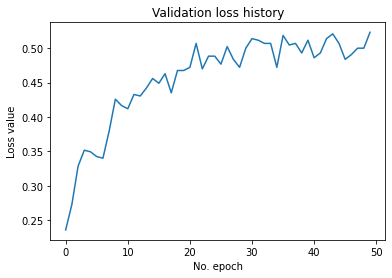

In [506]:
plt.plot(model_results[16][0].history['val_accuracy'])
plt.title('Validation loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

In [582]:
model_results

{2: [<keras.callbacks.History at 0x7f8f638eccd0>,
  <keras.callbacks.History at 0x7f8f6d8292b0>]}

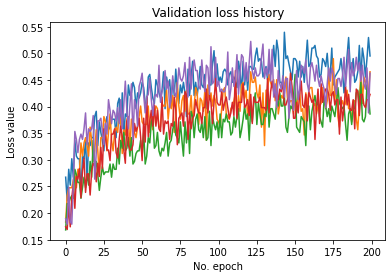

In [583]:
plt.plot(model_results[2][0].history['val_accuracy'])
plt.plot(model_results[2][1].history['val_accuracy'])
plt.plot(model_results[2][2].history['val_accuracy'])
plt.plot(model_results[2][3].history['val_accuracy'])
plt.plot(model_results[2][4].history['val_accuracy'])
plt.title('Validation loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

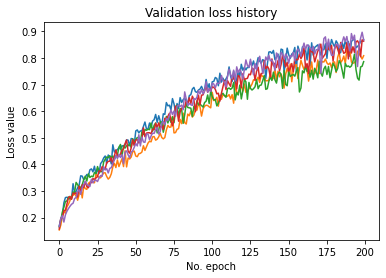

In [584]:
plt.plot(model_results[2][0].history['accuracy'])
plt.plot(model_results[2][1].history['accuracy'])
plt.plot(model_results[2][2].history['accuracy'])
plt.plot(model_results[2][3].history['accuracy'])
plt.plot(model_results[2][4].history['accuracy'])
plt.title('Validation loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

In [155]:
model_cnn = Sequential()
model_cnn.add(Conv1D(64,kernel_size=5,strides=1,activation='relu',input_shape=(X_train_cnn.shape[1],1)))
model_cnn.add(BatchNormalization())
# model_cnn.add(Conv1D(64,kernel_size=5,strides=1,activation='relu'))
model_cnn.add(Dropout(0.1))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPooling1D(pool_size=8,strides=2))
model_cnn.add(Conv1D(32,kernel_size=5,activation='relu'))
# model_cnn.add(Conv1D(32,kernel_size=5,activation='relu'))
# model_cnn.add(Conv1D(32,kernel_size=5))
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.2))
model_cnn.add(Flatten())
model_cnn.add(Dense(32))
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(8))
model_cnn.compile(optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'])

model_cnn.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_44 (Conv1D)           (None, 43, 64)            384       
_________________________________________________________________
batch_normalization_6 (Batch (None, 43, 64)            256       
_________________________________________________________________
dropout_48 (Dropout)         (None, 43, 64)            0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 43, 64)            256       
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 18, 64)            0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 14, 32)            10272     
_________________________________________________________________
batch_normalization_8 (Batch (None, 14, 32)          

In [156]:
tb = time_for_batch()
te = time_for_epoch()

history = model_cnn.fit(X_train_cnn, Y_train_cnn,
                      batch_size=4,
                      epochs=100,
                      verbose=2,
                      use_multiprocessing=False,
                      callbacks = [tb, te],
                      validation_data=(X_test_cnn, Y_test_cnn))

Epoch 1/100
252/252 - 2s - loss: 7.4596 - accuracy: 0.1420 - val_loss: 9.3587 - val_accuracy: 0.1250
Epoch 2/100
252/252 - 1s - loss: 6.5239 - accuracy: 0.1480 - val_loss: 5.1971 - val_accuracy: 0.1019
Epoch 3/100
252/252 - 1s - loss: 5.4774 - accuracy: 0.1221 - val_loss: 4.7286 - val_accuracy: 0.1574
Epoch 4/100
252/252 - 1s - loss: 4.8253 - accuracy: 0.1460 - val_loss: 4.6585 - val_accuracy: 0.1343
Epoch 5/100
252/252 - 1s - loss: 4.3213 - accuracy: 0.1460 - val_loss: 4.6593 - val_accuracy: 0.1343
Epoch 6/100
252/252 - 1s - loss: 4.3158 - accuracy: 0.1450 - val_loss: 4.6137 - val_accuracy: 0.1250
Epoch 7/100
252/252 - 1s - loss: 4.3195 - accuracy: 0.1400 - val_loss: 4.6410 - val_accuracy: 0.1481
Epoch 8/100
252/252 - 1s - loss: 4.4920 - accuracy: 0.1400 - val_loss: 5.4338 - val_accuracy: 0.1458
Epoch 9/100
252/252 - 1s - loss: 7.5099 - accuracy: 0.1281 - val_loss: 6.7937 - val_accuracy: 0.1412
Epoch 10/100
252/252 - 1s - loss: 7.3924 - accuracy: 0.1380 - val_loss: 6.6392 - val_accura